In [ ]:
pip install geneticalgorithm

     |████████████████████████████████| 51kB 3.0MB/s 
  Created wheel for func-timeout: filename=func_timeout-4.3.5-cp36-none-any.whl size=15078 sha256=033dd090c9a63cc3a7a34705e30411b75071c9a63c9c809748bb5d06fc638b48
  Stored in directory: /root/.cache/pip/wheels/46/7c/4f/24f1d2d5bbff92219debe7ea19af84f76ddeb90dd4ec544f26
Successfully built func-timeout


504.7791413661411


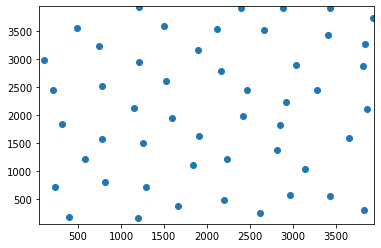

In [ ]:
from math import sin, cos, sqrt
import random
import numpy as np
import matplotlib.pyplot as plt
from random import randrange, uniform
import matplotlib.pyplot as plt


from Farm_Evaluator_grasp import getTurbLoc, loadPowerCurve, binWindResourceData, preProcessing, preProcessing_greedy, getAEP, getAEP_greedy, getAEP_greedy_all_years, getAEP_all_years, checkConstraints
from poisson_dist import Bridson_sampling

num_turbines = 1

# Turbine Specifications.
# -**-SHOULD NOT BE MODIFIED-**-
turb_specs    =  {   
                     'Name': 'Anon Name',
                     'Vendor': 'Anon Vendor',
                     'Type': 'Anon Type',
                     'Dia (m)': 100,
                     'Rotor Area (m2)': 7853,
                     'Hub Height (m)': 100,
                     'Cut-in Wind Speed (m/s)': 3.5,
                     'Cut-out Wind Speed (m/s)': 25,
                     'Rated Wind Speed (m/s)': 15,
                     'Rated Power (MW)': 3
                 }
turb_diam      =  turb_specs['Dia (m)']
turb_rad       =  turb_diam/2 

# Turbine x,y coordinates
turb_coords   =  getTurbLoc('turbine_loc_test.csv')

# Load the power curve
power_curve   =  loadPowerCurve('power_curve.csv')

# Pass wind data csv file location to function binWindResourceData.
# Retrieve probabilities of wind instance occurence.
wind_inst_freq =  binWindResourceData('wind_data_2007.csv')   

wind_data = [
'wind_data_2007.csv',
'wind_data_2008.csv',
'wind_data_2009.csv',
'wind_data_2013.csv',
'wind_data_2014.csv',
'wind_data_2015.csv',
'wind_data_2017.csv'
]


# Doing preprocessing to avoid the same repeating calculations. Record 
# the required data for calculations. Do that once. Data are set up (shaped)
# to assist vectorization. Used later in function totalAEP.
n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = preProcessing_greedy(power_curve, num_turbines)

def greedy_randomized_solution(alpha):
    width = 3900
    height = 3900
    n_turbs = 50
    points = Bridson_sampling(width=width, height=height, radius=400, k=10000)
    for i in points:
        i[0] = i[0] + 50
        i[1] = i[1] + 50
    solution = np.array([[]])
    solution = np.array([], dtype=np.int64).reshape(0,2)
    best_value = 0
    best_point = 0
    x = np.array([[]])
    for i in range(n_turbs):
        best_value = 0
        eval_list = []
        for j in range(len(points)):
            objec = points[j]
            if(objec not in solution):
                solution = np.vstack((solution, objec))
                obj = getAEP_greedy_all_years(turb_rad, solution, power_curve, wind_data, n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 
                eval_list.append((j, obj))
                if(obj >= best_value):
                    best_value = obj
                    best_point = objec
                solution = np.delete(solution, len(solution) - 1, 0)
        sorted_vec = sorted(eval_list, key=lambda tup: tup[1], reverse=True)
        positions = int((len(sorted_vec)-1)*alpha)
        pos  = random.randint(0, positions)
        point = points[sorted_vec[pos][0]]
        solution = np.vstack((solution, point))
    neighbors = np.array(list(filter(lambda x: x not in solution, points)))
    return solution, points


def greedy_solution():
    width = 3900
    height = 3900
    n_turbs = 50
    points = Bridson_sampling(width=width, height=height, radius=400, k=10000)
    for i in points:
        i[0] = i[0] + 50
        i[1] = i[1] + 50
    solution = np.array([[]])
    solution = np.array([], dtype=np.int64).reshape(0,2)
    best_value = 0
    best_point = 0
    x = np.array([[]])
    for i in range(n_turbs):
        best_value = 0
        for j in range(len(points)):
            objec = points[j]
            if(objec not in solution):
                solution = np.vstack((solution, objec))
                obj = getAEP_greedy_all_years(turb_rad, solution, power_curve, wind_data, n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 
                if(obj >= best_value):
                    best_value = obj
                    best_point = objec
                solution = np.delete(solution, len(solution) - 1, 0)
        solution = np.vstack((solution, best_point))
    neighbors = np.array(list(filter(lambda x: x not in solution, points)))
    return solution

def perturb(solution, neighbors, position, best_value):
    best_point = solution[position]
    print("Initial ", best_value)
    for i in neighbors:
        solution[position] = i
        obj = getAEP_all_years(turb_rad, solution, power_curve, wind_data, n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 
        if(obj >= best_value):
            best_value = obj
            best_point = i
    solution[position] = best_point
    print("Later ", best_value)

    return solution, best_value

def local_search(solution, points):
    best_solution = solution.copy()
    neighbors = np.array(list(filter(lambda x: x not in solution, points)))
    best_value = getAEP_all_years(turb_rad, solution, power_curve, wind_data, n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 
    for position in range(n_turbs):
        solution = best_solution.copy()
        improved = False
        for i in neighbors:
            solution[position] = i.copy()
            value = getAEP_all_years(turb_rad, solution, power_curve, wind_data, n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 
            if(value >= best_value):
                best_value = value
                best_point = i
                improved = True
                best_solution = solution.copy()
        neighbors = np.array(list(filter(lambda x: x not in best_solution, points)))
    return best_solution, best_value

def grasp(max_iter, alpha):
    best_solution = np.array([[]])
    best_solution = np.array([], dtype=np.int64).reshape(0,2)
    best_value = 0
    for position in range(max_iter):
        solution, points = greedy_randomized_solution(alpha)
        solution, value = local_search(solution, points)
        print(value, best_value)
        if(value >= best_value):
            best_value = value
            best_solution = solution.copy()
    return best_solution, best_value

def check_difference(num, vec, max_dist_lines):
    for i in vec:
        if(abs(i-num) < max_dist_lines):
            return False
    return True

def check_distances(point, all_points, max_dist):
    for i in all_points:
        p1, p2 = np.array(i), np.array(point)
        dist = np.linalg.norm(p1 - p2)
        if(dist < max_dist):
            return False
    return True

theta = 1.4835298641952
a1 = 100
a2 = 200
points_x = []
points_y = []
points = []
b = 1000
max_dist_lines = 400*(sqrt(pow(theta, 2)+1))
all_gen = []
solution = np.array([[]])
solution = np.array([], dtype=np.int64).reshape(0,2)
max_num_points = 25
still_try = True
same_direction = []
b = uniform(-5809, 3875)
iterations = 0
while(len(points) < 50):
    if(not still_try):
        b = uniform(-5809, 3875)
        x = uniform(50, 3950)
        y = x*theta + b
        if(y >= 50 and y <= 3950 and check_distances((x,y),points,400)):
            all_gen.append(b)
            points_x.append(x)
            points_y.append(y)
            points.append((x,y))
            solution = np.vstack((solution, np.array((x,y))))
            still_try = True
            same_direction.append((x,y))
    else:
        x = uniform(50, 3950)
        y = x*theta + b
        if(y >= 50 and y <= 3950 and check_distances((x,y),points,400) and check_distances((x,y),same_direction,600)):
            points_x.append(x)
            points_y.append(y)
            points.append((x,y))
            solution = np.vstack((solution, np.array((x,y))))
            same_direction.append((x,y))
        else:
            iterations += 1
        if(iterations >= max_num_points):
            iterations = 0
            still_try = False
            same_direction = []


sol_value = getAEP_all_years(turb_rad, solution, power_curve, wind_data, n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 
print(sol_value)


plt.ylim((50, 3950))
plt.xlim((50, 3950))

plt.scatter(points_x, points_y)
plt.show()

n_turbs = 50
alpha = 0.3
a, b = grasp(10, alpha)

# sol1 = greedy_randomized_solution(alpha)
# best_solution = getAEP_all_years(turb_rad, sol1, power_curve, wind_inst_freq, n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 
# checkConstraints(sol1, turb_diam)
# print(best_solution)

# sol2 = greedy_solution()
# best_solution = getAEP_all_years(turb_rad, sol2, power_curve, wind_inst_freq, n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 
# checkConstraints(sol2, turb_diam)
# print(best_solution)

# for i in range(50):
#     if(sol1[i] in sol2):
#         print("tem")
#     else:
#         print("não tem")

# n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = preProcessing(power_curve)
# solu = local_search(sol)
# best_solution = getAEP_all_years(turb_rad, solu, power_curve, wind_inst_freq, n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 
# print(best_solution)
